In [127]:
import numpy as np
import pandas as pd
import os
import scipy.io
from scipy.signal import butter, filtfilt, iirnotch, cheby2
from einops import rearrange
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, cohen_kappa_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import pywt
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from mne.decoding import CSP
import mne

In [2]:
FS = 250
sns.set_style("darkgrid")

## Loading the data

In [3]:
def load_data(folder,idx):
	path_train = os.path.join(folder,f"B0{idx}T.mat")
	path_test = os.path.join(folder,f"B0{idx}E.mat")
	mat_train = scipy.io.loadmat(path_train)["data"]
	mat_test = scipy.io.loadmat(path_test)["data"]
	return mat_train,mat_test
	

In [4]:
dataset = {}
for i in range(1,10):
	mat_train,mat_test = load_data("../data/2b_iv",i)
	dataset[f"subject_{i}"] = {"train":mat_train,"test":mat_test}

- shape: 1 x n_trials
- 3 training trials, 2 testing trials

- data is contained in tuple of 8 elements
  - electrode data of shape $L \times 6$
  - time stamp indices for the cues of shape 120
  - cues (1 or 2) of shape 120
  - sampling frequency
  - mapping 1,2 to left hand right hand?
  - artifact identification (hand picked by experts)
  - subject sex
  - subject age

In [5]:
class subject_dataset:

	def __init__(self,
			  mat,
			  fs = 250,
			  t_baseline = 0.3,
			  t_epoch = 4):

		self.fs = fs
		self.t_baseline = t_baseline
		self.t_epoch = t_epoch

		self.epochs = []
		self.cues = []
		self.dfs = []
		self.timestamps = []

		for i in range(mat.shape[-1]):
			epochs,cues,df = self.load_data(mat,i)
			self.epochs.append(epochs)
			self.cues.append(cues)
			self.dfs.append(df)

		self.epochs = np.concatenate(self.epochs,axis=0)
		# removing 1 to get 0,1 instead of 1,2
		self.cues = np.concatenate(self.cues,0)	- 1	

	def load_data(self,mat,index=0):

		"""
		Loading the epochs,cues, and dataframe for one trial
		For now, we are not removing samples with artifacts
		since it can't be done on the fly.

		Args:
			mat: array
			index: trial index

		Returns:
			epochs: array of epoch electrode data
			cues: array of cues (labels) for each epoch
			df: dataframe of trial data
		"""
		
		electrodes = mat[0][index][0][0][0].squeeze()
		timestamps = mat[0][index][0][0][1].squeeze()
		cues = mat[0][index][0][0][2].squeeze()
		artifacts = mat[0][index][0][0][5]

		epochs,cues = self.create_epochs(electrodes,timestamps,artifacts,cues,
							  self.t_baseline,self.t_epoch,self.fs)
		
		
		df = self.load_df(timestamps,electrodes,cues)
		return epochs,cues,df

	def create_epochs(self,
				   electrodes,
				   timestamps,
				   artifacts,
				   cues,
				   t_baseline,
				   t_epoch,
				   fs):
		
		"""
		creating an array with all epochs from a trial

		Args:
			electrode: electrode data
			timestamps: cue indices
			artifacts: artifact presence array
			cues: labels for cues
			t_baseline: additional time for baseline
			t_epoch: time of epoch
		"""
		
		n_samples = int(fs*t_epoch)
		n_samples_baseline = int(fs*t_baseline)
		epochs = []
		cues_left = []
		for i,j,c in zip(timestamps,artifacts,cues):
			if j==0:
				epochs.append(electrodes[i-n_samples_baseline:i+n_samples,:])
				cues_left.append(c)
		epochs = np.stack(epochs)
		cues_left = np.asarray(cues_left)
		return epochs,cues_left

	def load_df(self,
			 timestamps,
			 electrodes,
			 cues):

		"""
		Loading the channel values and adding a timestamp column.
		Useful for visualizing an entire trial

		Args:
			None
		Returns:
			None
		"""

		timeline = np.zeros_like(electrodes[:,0])

		for t,c in zip(timestamps,cues):
			timeline[t] = c

		df = pd.DataFrame(electrodes)

		df["timestamps"] = timeline

		return df
	
	def trial_preprocess(x,*args,**kwargs):
		"""
		Pre-processing step to be applied to entire trial.
		"""
		return x

In [6]:
class Classifier:

	def __init__(self,
			  dataset,
			  t_baseline=0,
			  t_epoch=4,
			  fs=250):
		
		self.fs = fs
		self.t_epoch = t_epoch
		self.t_baseline = t_baseline
		self.train_epochs = []
		self.train_y = []
		self.val_epochs = []
		self.val_y = []

		for k,v in dataset.items():
			s_train = subject_dataset(v["train"],fs,t_baseline,t_epoch)
			s_val = subject_dataset(v["test"],fs,t_baseline,t_epoch)
			self.train_epochs.append(s_train.epochs)
			self.train_y.append(s_train.cues)
			self.val_epochs.append(s_val.epochs)
			self.val_y.append(s_val.cues)

		self.train_epochs = rearrange(np.concatenate(self.train_epochs,0),"n t d -> n d t")
		self.val_epochs = rearrange(np.concatenate(self.val_epochs,0),"n t d -> n d t")
		self.train_y = np.concatenate(self.train_y,0)
		self.val_y = np.concatenate(self.val_y,0)

		self.x_train,self.y_train = self.preprocess(self.train_epochs,self.train_y)
		self.x_val,self.y_val = self.preprocess(self.val_epochs,self.val_y)

	def fit(self,*args,**kwargs):
		pass

	def filter(self,x):

		"""
		Apply a sequence of filters to a set of measurements
		"""
		return x
	
	def preprocess(self,x,y):

		"""
		Apply filters and additional preprocessing to measurements
		"""

		n,t,d = x.shape

		x = rearrange(x,"n d t -> (n d) t")
		x = self.filter(x)
		x = rearrange(x,"(n d) t -> n d t",n=n)

		return x,y
	
	def predict(self,x):

		"""
		Returns a continuous and a discrete prediction
		"""
		
		y = np.random.random(x.shape[0])
		return y,np.round(y)
	
	def get_train(self):
		return self.x_train,self.y_train
	
	def get_test(self):
		return self.x_val,self.y_val
	
	def test(self,
		  verbose=True):

		outs = {}
		for split in ["train","test"]:
			x,y = self.get_test() if split == "test" else self.get_train()
			y_pred,y_discrete = self.predict(x)
			
			acc = accuracy_score(y,y_discrete)
			confusion = confusion_matrix(y,y_discrete,normalize="true")

			kappa = cohen_kappa_score(y_discrete,y)

			if verbose:

				print(f"{split} kappa score: {kappa}")

				print(f"{split} accuracy: {acc}")
				print(confusion)
				cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])
				cm_display.plot()
				plt.show()
			outs[split] = (y,y_pred,y_discrete,acc,kappa)
		return outs
		
	def plot_first(self,i=0):

		plt.plot(self.x_train[i,0,:],label="clean")
		plt.plot(self.train_epochs[i,0,:],alpha=0.5,label="raw")
		plt.legend()
		plt.show()

In [7]:
class SubjectClassifier:

	def __init__(self,
			  classifier: Classifier,
			  dataset,
			  *args,
			  **kwargs):
		
		self.classifiers = {}

		for k,v in dataset.items():
			d = {k:dataset[k]}
			self.classifiers[k] = classifier(d,*args,**kwargs)

	def fit(self,*args,**kwargs):

		for k,v in self.classifiers.items():
			v.fit(*args,**kwargs)

	def test(self):
		
		full_y = {"train":[],"test":[]}
		full_y_pred = {"train":[],"test":[]}
		full_y_discrete = {"train":[],"test":[]}
		accuracy_scores = []
		kappa_scores = []

		for k,v in self.classifiers.items():
			outs = v.test(verbose=False)
			subject_acc = []
			subject_kappa = []
			for split in outs.keys():
				y,y_pred,y_discrete,acc,kappa = outs[split]
				full_y[split].append(y)
				full_y_pred[split].append(y_pred)
				full_y_discrete[split].append(y_discrete)
				subject_acc.append(acc)
				subject_kappa.append(kappa)
			kappa_scores.append(subject_kappa)
			accuracy_scores.append(subject_acc)
		
		for split in ["train","test"]:
			y = np.concatenate(full_y[split])
			y_pred = np.concatenate(full_y_pred[split])
			y_discrete = np.concatenate(full_y_discrete[split])
			acc = accuracy_score(y,y_discrete)
			confusion = confusion_matrix(y,y_discrete,normalize="true")

			kappa = cohen_kappa_score(y_discrete,y)

			print(f"{split} kappa score: {kappa}")

			print(f"{split} accuracy: {acc}")
			print(confusion)
			cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion, display_labels = [False, True])
			cm_display.plot()
			plt.show()

		accuracy_scores = np.asarray(accuracy_scores)
		kappa_scores = np.asarray(kappa_scores)

		return accuracy_scores,kappa_scores

In [119]:
class CSPClassifier(Classifier):

	def __init__(self,
				dataset,
				t_baseline,
				t_epoch,
				start=3.75,
				length = 0.5,
				fs=250):

		super().__init__(dataset,t_baseline,t_epoch,fs)

		self.csp = CSP(n_components=18,reg=None,log=True,norm_trace=False)
		self.svm = SVC(C=1)

		self.clf = Pipeline(steps=[("csp",self.csp),
							 ("selection",SelectKBest(mutual_info_classif)),
							("classification",self.svm)])
		self.set_epoch(start,length)

	def set_epoch(self,start,length):
		self.input_start = start + self.t_baseline
		self.input_end = self.input_start + length

	def gridCV(self,
			param_grid,
			n_jobs = 4):
		x,y = self.get_train()
		x = x[:,:,int(self.input_start*250):int(self.input_end*250)]
		search = GridSearchCV(self.clf,param_grid,n_jobs=n_jobs)
		search.fit(x,y)
		print(search.best_params_)
		print(f"accuracy of: {search.best_estimator_.score(x,y)}")
		self.clf = search.best_estimator_
		
	def fit(self):
		x,y = self.get_train()
		x = x[:,:,int(self.input_start*250):int(self.input_end*250)]
		self.clf.fit(x,y)

	def predict(self, x):
		x = x[:,:,int(self.input_start*250):int(self.input_end*250)]
		y_cont = self.clf.decision_function(x)
		y_discrete = self.clf.predict(x)
		return y_cont,y_discrete
	
	def filter(self,
			x,
			notch_freq=50):
		
		nyquist = self.fs/2
		b,a = iirnotch(notch_freq,30,self.fs)
		x = filtfilt(b,a,x)
		return x
	
	def passband(self,
			  x,
			  low,
			  high):
		
		nyquist = self.fs/2
		b,a = butter(4,[low/nyquist,high/nyquist],"bandpass",analog=False)
		n,d,t = x.shape
		x = rearrange(x,"n d t -> (n d) t")
		x = filtfilt(b,a,x)
		x = rearrange(x,"(n d) t -> n d t",n=n)
		return x
	
	def preprocess(self, x, y):
		x,y = super().preprocess(x, y)
		x = x[:,[0,2],:]
		ax = []

		for i in range(1,10):
			ax.append(self.passband(x,4*i,4*i+4))
		x = np.concatenate(ax,1)
		mu = np.mean(x,axis=-1)
		sigma = np.std(x,axis=-1)
		x = (x-rearrange(mu,"n d -> n d 1"))/rearrange(sigma,"n d -> n d 1")
		return x,y
	

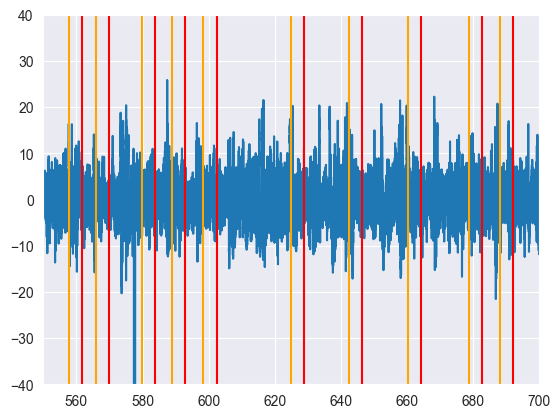

In [44]:
s1 = subject_dataset(dataset["subject_1"]["train"],t_baseline=-2,t_epoch=5)

cues_points = np.asarray(s1.dfs[0]["timestamps"][s1.dfs[0]["timestamps"]!=0].index)/250
end_points = (np.asarray(s1.dfs[0]["timestamps"][s1.dfs[0]["timestamps"]!=0].index)/250)+4

amplitude = s1.dfs[0][2]
amplitude.shape
t = np.linspace(0,amplitude.shape[0]/250,amplitude.shape[0])
plt.plot(t,amplitude)
plt.vlines(cues_points,ymin=-60,ymax=60,colors=["orange"])
plt.vlines(end_points,ymin=-60,ymax=60,colors=["red"])
plt.xlim([550,700])
plt.ylim([-40,40])
plt.show()

In [148]:
classifier = CSPClassifier(dataset,t_baseline=0,t_epoch=9)

In [150]:
x,y = classifier.get_train()

In [151]:
x.shape

(3026, 18, 2250)

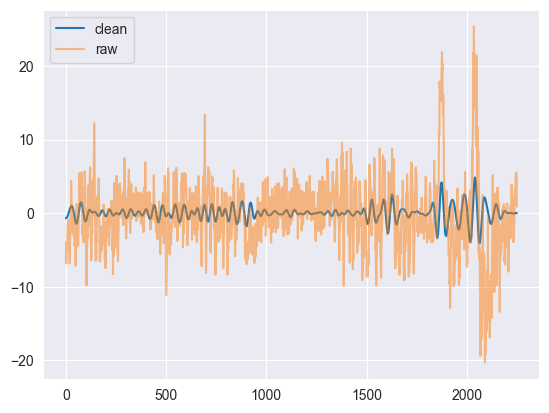

In [152]:
classifier.plot_first(0)

In [153]:
classifier.set_epoch(3.75,1.5)

In [154]:
selectkbest_params = {
	"selection__k":["all"]
}

svc_params = {
    'classification__C': [1, 10,100,1000], 
	"classification__kernel":["rbf"]
}

param_grid = {**svc_params,**selectkbest_params}

In [156]:
%%capture
classifier.fit()

train kappa score: 0.4335479632005669
train accuracy: 0.716787838730998
[[0.75363276 0.24636724]
 [0.32010582 0.67989418]]


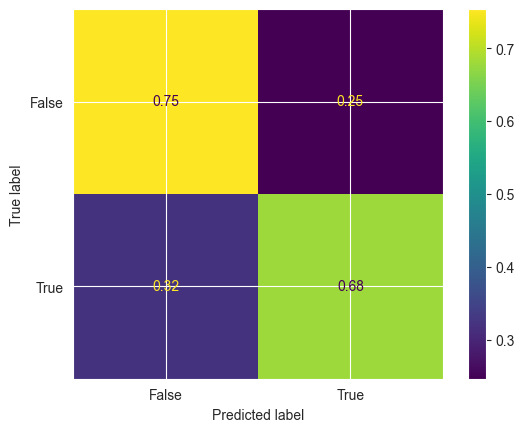

test kappa score: 0.372757013978388
test accuracy: 0.6863007585899152
[[0.74239714 0.25760286]
 [0.36954586 0.63045414]]


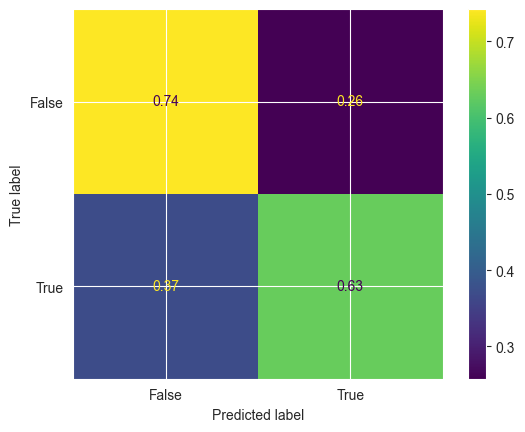

In [157]:
_ = classifier.test()

In [158]:
class PerSubjectCSP(SubjectClassifier):

	def __init__(self, classifier: CSPClassifier, dataset, *args, **kwargs):
		super().__init__(classifier, dataset, *args, **kwargs)

	def set_epoch(self,start,length):
		for k,v in self.classifiers.items():
			v.set_epoch(start,length)

	def fit(self,param_grid,n_jobs = 1):
		for k,v in self.classifiers.items():
			v.fit()
			# v.gridCV(param_grid,n_jobs)

In [176]:
persub = PerSubjectCSP(CSPClassifier,dataset,t_baseline=0,t_epoch=6,start=3.75,length=1.5)

In [177]:
csp_params = {
    'csp__n_components': [18],
}


selectkbest_params = {
	"selection__k":[4,8,12,"all"]
}

svc_params = {
    'classification__C': [0.1, 1, 10,100], 
	"classification__kernel":["rbf","linear"]
}

param_grid = {**csp_params, **svc_params,**selectkbest_params}

In [178]:
%%capture
persub.set_epoch(3.75,2)
persub.fit(param_grid,1)

train kappa score: 0.6186378002459412
train accuracy: 0.8093192333113021
[[0.81043593 0.18956407]
 [0.19179894 0.80820106]]


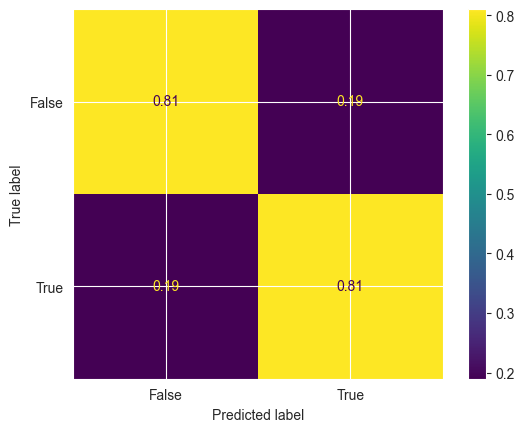

test kappa score: 0.4323120380711428
test accuracy: 0.7161981258366801
[[0.68336315 0.31663685]
 [0.25111309 0.74888691]]


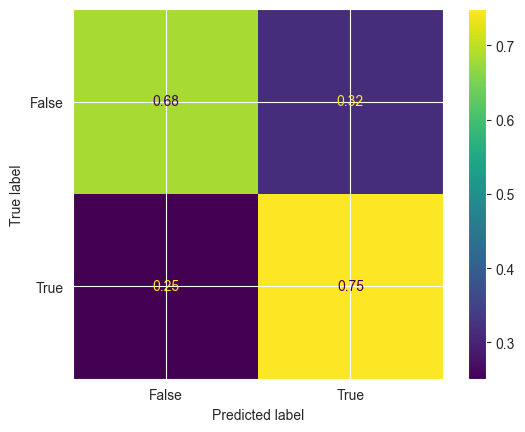

In [179]:

acc,kappa = persub.test()

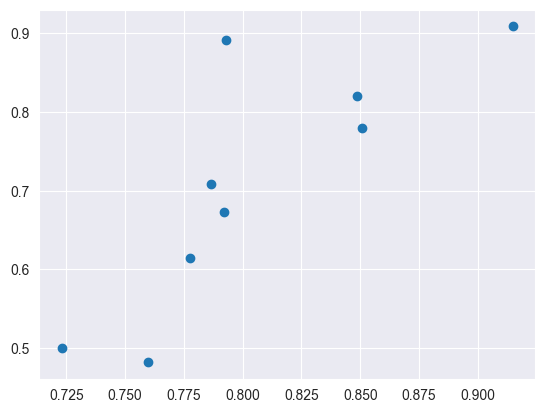

In [180]:
plt.scatter(acc[:,0],acc[:,1])
plt.show()

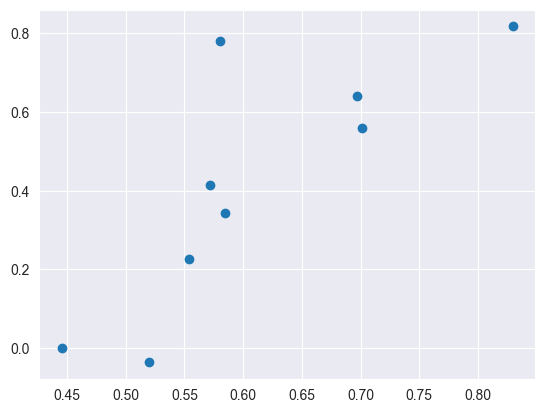

In [181]:
plt.scatter(kappa[:,0],kappa[:,1])
plt.show()